#### **Importing Libraries**

In [1]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast
from tensorflow.keras.layers import Reshape

In [2]:
data = pd.read_csv('creditcard.csv', na_filter=True)
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [3]:
data.shape

(284807, 31)

In [4]:
tr_data = data.drop(col_del,axis =1)
tr_data.shape

(284807, 10)

In [5]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']
X.shape

(284807, 9)

In [7]:
# Generate and plot imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(tr_data['Class'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(tr_data['Class'] == label)[0]

Counter({0: 284315, 1: 492})


#### **Oversampling the Data**

In [8]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]

Counter({0: 284315, 1: 284315})


In [9]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.2)

In [11]:
X_train.shape

(454904, 9)

In [12]:
X_test.shape

(113726, 9)

#### **Design  the Network**

In [14]:
# design network
np.random.seed(7)

# X_train and X_test are the input data
train_LSTM_X = X_train
val_LSTM_X = X_test

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y = y_train  #
val_LSTM_y = y_test

In [16]:
inputs = Input((1,9))   # 9 features
x1 = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(inputs)   # 50 LSTM units
x2 = Reshape((1, 50))(x1)  # add Reshape layer to convert to 3D tensor
x3 = LSTM(50, dropout=0.3, recurrent_dropout=0.2)(x2)   # 50 LSTM units
outputs = Dense(1, activation='sigmoid')(x3)    # 1 output neuron
model=Model(inputs,outputs)

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=100,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))

Epoch 1/100
23/23 [==============================] - 26s 657ms/step - loss: 0.6687 - accuracy: 0.7918 - val_loss: 0.6253 - val_accuracy: 0.8872
Epoch 2/100
23/23 [==============================] - 12s 515ms/step - loss: 0.5698 - accuracy: 0.8828 - val_loss: 0.4859 - val_accuracy: 0.8898
Epoch 3/100
23/23 [==============================] - 11s 482ms/step - loss: 0.4289 - accuracy: 0.8848 - val_loss: 0.3555 - val_accuracy: 0.8985
Epoch 4/100
23/23 [==============================] - 13s 565ms/step - loss: 0.3251 - accuracy: 0.8965 - val_loss: 0.2798 - val_accuracy: 0.9068
Epoch 5/100
23/23 [==============================] - 20s 881ms/step - loss: 0.2727 - accuracy: 0.9075 - val_loss: 0.2429 - val_accuracy: 0.9104
Epoch 6/100
23/23 [==============================] - 15s 661ms/step - loss: 0.2460 - accuracy: 0.9135 - val_loss: 0.2190 - val_accuracy: 0.9163
Epoch 7/100
23/23 [==============================] - 14s 613ms/step - loss: 0.2310 - accuracy: 0.9169 - val_loss: 0.2042 - val_accuracy:

KeyboardInterrupt: 

In [117]:
# save model and architecture to single file
model.save('Save_Model.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Save_Model.h5')
# summarize model.
model.summary()

In [119]:
# evaluate the model
_, train_acc = model.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.938, Test: 0.936


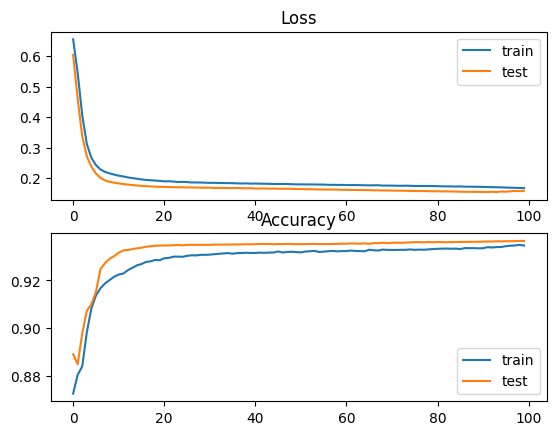

In [120]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [121]:
# predict probabilities for test set
yhat_probs = model.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
# yhat_probs.shape
# yhat_probs

In [122]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
# convert val_LSTM_y to numpy array
val_LSTM_y = np.array(val_LSTM_y)
yhat_binary = (yhat_probs > 0.5).astype(int) # convert to binary values
# print(yhat_binary.shape)
accuracy = accuracy_score(val_LSTM_y, yhat_binary)
# print("Accuracy:", accuracy)
# accuracy = accuracy_score(val_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_binary)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_binary)
print('Recall: %f' % recall)


Accuracy: 0.936461
Precision: 0.989924
Recall: 0.881364


In [123]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [124]:
cm = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_binary)

In [125]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[56591   508]
 [ 6718 49909]]


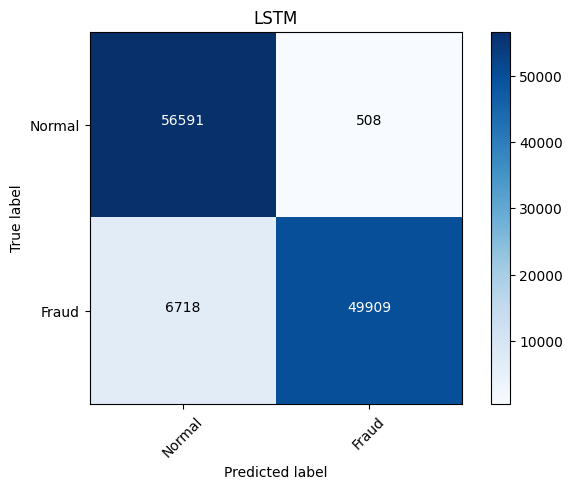

In [126]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')

In [127]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [128]:
inputs1=Input((1,9))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(inputs1,outputs1)

In [129]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [131]:
history1=model1.fit(train_LSTM_X, train_LSTM_y,epochs=100,batch_size=30000, validation_data=(val_LSTM_X, val_LSTM_y))

Epoch 1/100
16/16 [==============================] - 16s 958ms/step - loss: 0.6530 - accuracy: 0.8720 - val_loss: 0.6164 - val_accuracy: 0.8810
Epoch 2/100
16/16 [==============================] - 14s 843ms/step - loss: 0.5833 - accuracy: 0.8788 - val_loss: 0.5224 - val_accuracy: 0.8808
Epoch 3/100
16/16 [==============================] - 13s 818ms/step - loss: 0.4848 - accuracy: 0.8783 - val_loss: 0.4215 - val_accuracy: 0.8827
Epoch 4/100
16/16 [==============================] - 11s 696ms/step - loss: 0.3932 - accuracy: 0.8842 - val_loss: 0.3420 - val_accuracy: 0.8937
Epoch 5/100
16/16 [==============================] - 11s 667ms/step - loss: 0.3271 - accuracy: 0.8944 - val_loss: 0.2896 - val_accuracy: 0.9042
Epoch 6/100
16/16 [==============================] - 11s 680ms/step - loss: 0.2862 - accuracy: 0.9030 - val_loss: 0.2586 - val_accuracy: 0.9077
Epoch 7/100
16/16 [==============================] - 11s 678ms/step - loss: 0.2613 - accuracy: 0.9088 - val_loss: 0.2364 - val_accuracy:

In [132]:
# save Attention model and architecture to single file
model1.save('Save_Model_Attention.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
# load model 
model1 = load_model('Save_Model_Attention.h5', custom_objects={'attention': attention})
# summarize model.
model1.summary()

In [134]:
# evaluate the model
_, train_acc = model1.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model1.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.937, Test: 0.935


In [135]:
# predict probabilities for test set
yhat_probs1 = model1.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs1 = yhat_probs1[:, 0]

In [136]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
yhat_binary1 = (yhat_probs1 > 0.5).astype(int) # convert to binary values
accuracy = accuracy_score(val_LSTM_y,yhat_binary1)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_binary1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_binary1)
print('Recall: %f' % recall)


Accuracy: 0.935424
Precision: 0.988444
Recall: 0.880605


In [137]:
cm1 = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_binary1)

Confusion matrix, without normalization
[[56516   583]
 [ 6761 49866]]


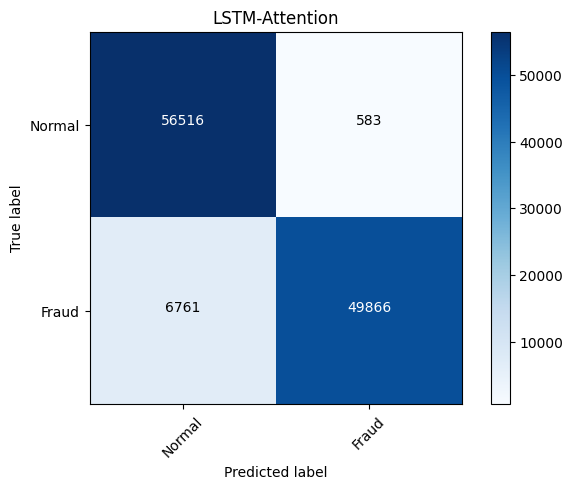

In [138]:
plot_confusion_matrix(cm=cm1, classes=labels, title='LSTM-Attention', normalize=False)